*Eduardus Tjitrahardja | @edutjie | 2022*

# Image Classification - VGGNet

## Importing Libraries

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation
from tensorflow.keras import regularizers, optimizers, Sequential
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

plt.style.use("seaborn")

In [2]:
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.9.1
/device:GPU:0
Num GPUs Available:  1


## Loading Data

In [3]:
IMG_SIZE = 224

In [4]:
def load_data(dir, labels = ["pumpkin", "tomato", "watermelon"],img_size = 224):
    data = []
    for label in labels:
        path = os.path.join(dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            img = cv2.imread(img_path)                      # load image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # convert image from BGR to RGB format
            img = cv2.resize(img, (img_size, img_size))     # resize image to the preferred size
            img = np.array(img) / 255.0                     # normalize data
            data.append([img, class_num])
    return np.array(data)

In [5]:
train_data = load_data("images\\train")
val_data = load_data("images\\validation")

len(train_data), len(val_data)

C:\Users\edutjie\AppData\Local\Temp\ipykernel_12488\943813668.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(3133, 824)

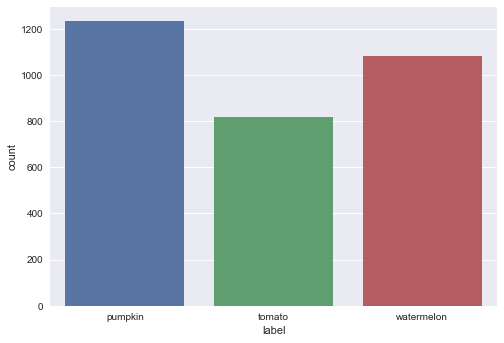

In [18]:
target_df = pd.DataFrame(train_data[:, 1], columns = ["label"])
target_df['label'] = target_df.label.map({0:'pumpkin', 1:'tomato', 2:'watermelon'})
sns.countplot(x='label',data=target_df)
plt.show()

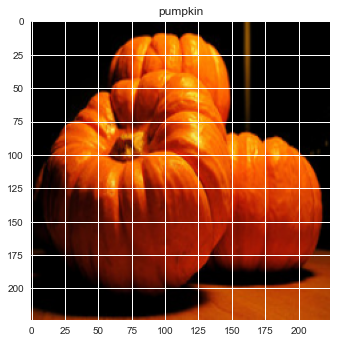

In [19]:
plt.imshow(train_data[0][0])
plt.title(target_df.label[0])
plt.show()

## Data Preprocessing

In [8]:
# seperate label and image array
train_img = []
train_labels = []

val_img = []
val_labels = []

for img, label in train_data:
    train_img.append(img)
    train_labels.append(label)

for img, label in val_data:
    val_img.append(img)
    val_labels.append(label)

# convert to np array
train_img = np.array(train_img)
train_labels = np.array(train_labels)
val_img = np.array(val_img)
val_labels = np.array(val_labels)

# # reshape data
# train_img = train_img.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
# val_img = val_img.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

print(f"Train Image Shape: {train_img.shape}")
print(f"Train Labels Shape: {train_labels.shape}\n")
print(f"Validation Image Shape: {val_img.shape}")
print(f"Validation Labels Shape: {val_labels.shape}")

Train Image Shape: (3133, 224, 224, 3)
Train Labels Shape: (3133,)

Validation Image Shape: (824, 224, 224, 3)
Validation Labels Shape: (824,)


### Convert Data to Categorical

In [9]:
train_labels = keras.utils.to_categorical(train_labels, 3)
val_labels = keras.utils.to_categorical(val_labels, 3)

train_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [10]:
print(f"Train Image Shape: {train_img.shape}")
print(f"Train Labels Shape: {train_labels.shape}\n")
print(f"Validation Image Shape: {val_img.shape}")
print(f"Validation Labels Shape: {val_labels.shape}")

Train Image Shape: (3133, 224, 224, 3)
Train Labels Shape: (3133, 3)

Validation Image Shape: (824, 224, 224, 3)
Validation Labels Shape: (824, 3)


## Define VGG Architecture

In [11]:
model = Sequential()
weight_decay = 0.0005
model_input = (IMG_SIZE, IMG_SIZE, 3)

model.add(Conv2D(64, (3, 3), padding='same', input_shape=model_input, kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 224, 224, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 224, 224, 64)      0         
                                                        

In [12]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

## Training VVG

In [13]:
path = 'checkpoints\\model_vgg.hdf5'

# Keep only a single checkpoint, the best over test accuracy.
checkpoint = ModelCheckpoint(path, monitor='val_acc', verbose=1, periode=5, mode='auto')

In [14]:
history = model.fit(train_img, train_labels, validation_data=(val_img, val_labels), epochs=5, batch_size=4, callbacks=[checkpoint])

Epoch 1/5
784/784 [==============================] - ETA: 0s - loss: 5.0269 - accuracy: 0.3824
Epoch 1: saving model to checkpoints\model_vgg.hdf5
784/784 [==============================] - 82s 93ms/step - loss: 5.0269 - accuracy: 0.3824 - val_loss: 5.0051 - val_accuracy: 0.4041
Epoch 2/5
783/784 [============================>.] - ETA: 0s - loss: 4.7896 - accuracy: 0.4183
Epoch 2: saving model to checkpoints\model_vgg.hdf5
784/784 [==============================] - 78s 100ms/step - loss: 4.7894 - accuracy: 0.4184 - val_loss: 4.7686 - val_accuracy: 0.3956
Epoch 3/5
783/784 [============================>.] - ETA: 0s - loss: 4.2838 - accuracy: 0.4116
Epoch 3: saving model to checkpoints\model_vgg.hdf5
784/784 [==============================] - 84s 107ms/step - loss: 4.2838 - accuracy: 0.4114 - val_loss: 4.0796 - val_accuracy: 0.3835
Epoch 4/5
783/784 [============================>.] - ETA: 0s - loss: 3.7693 - accuracy: 0.4352
Epoch 4: saving model to checkpoints\model_vgg.hdf5
784/784 [==

## Evaluate VGG

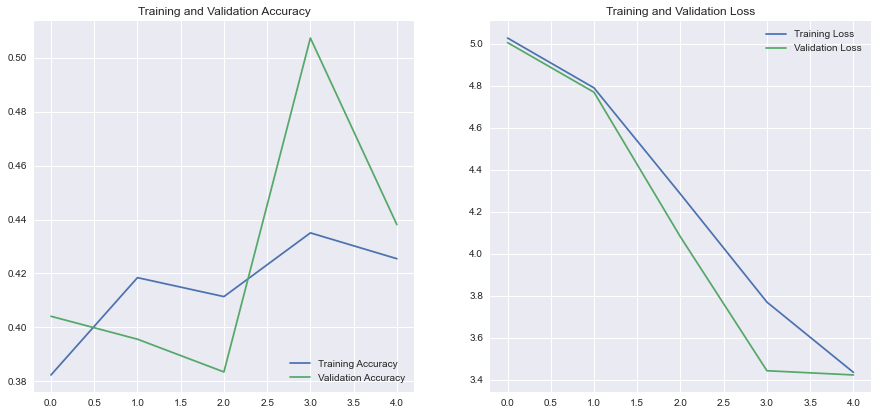

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()